# Step 2: Building GTFS graphs and merging it with a walking graph
We heavily follow Kuan Butts's Calculating Betweenness Centrality with GTFS blog post: https://gist.github.com/kuanb/c54d0ae7ee353cac3d56371d3491cf56

### The peartree (https://github.com/kuanb/peartree) source code was modified. Until code is merged you should use code from this fork: https://github.com/d3netxer/peartree

In [418]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [419]:
import matplotlib.pyplot as plt
%matplotlib inline

In [420]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point

In [421]:
import partridge as ptg

In [422]:
import os, sys

In [423]:
sys.path.append(r"C:\repos\peartree")
import peartree as pt

In [424]:
print(pt.__file__)

C:\repos\peartree\peartree\__init__.py


In [425]:
path = r'input_folder/cap_haitien_gtfs.zip'

### Build a graph from service_0001
service_0001 is on the weekends, so below we are choosing a data that lands on a weekend

In [426]:
# from: http://simplistic.me/playing-with-gtfs.html
import datetime

service_ids_by_date = ptg.read_service_ids_by_date(path)
service_ids = service_ids_by_date[datetime.date(2019, 6, 29)]

print(f"service_ids is {service_ids}")

# view lets you filter before you load the feed. For example, below you are filtering by the service_ids
feed_0001 = ptg.load_feed(path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

service_ids is frozenset({'service_0001'})


In [427]:
feed_0001.calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,service_0001,0,0,0,0,0,1,1,2019-06-29,2020-07-29


### give all trips a direction of 0
PearTree wants directions assigned

In [428]:
feed_0001.trips['direction_id'] = 0

### Preview the GTFS network

In [429]:
# Set a target time period to summarize impedance
start = 0  # 0:00 
end = 24*60*60  # 24:00 

# Converts feed subset into a directed
# network multigraph
G = pt.load_feed_as_graph(feed_0001, start, end, add_trips_per_edge=True)

C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


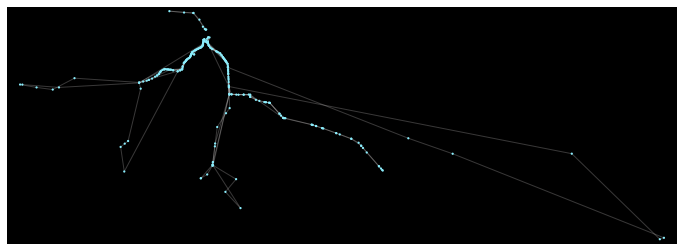

In [430]:
fig, ax = ox.plot_graph(G,
                            figsize=(12,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

In [431]:
# PearTree prepends the stop ids with a code the is different each time it loads a graph
list(G.edges)

[('2IJ7C_stop_0119', '2IJ7C_stop_0096', 0),
 ('2IJ7C_stop_0143', '2IJ7C_stop_0260', 0),
 ('2IJ7C_stop_0143', '2IJ7C_stop_0081', 0),
 ('2IJ7C_stop_0143', '2IJ7C_stop_0154', 0),
 ('2IJ7C_stop_0176', '2IJ7C_stop_0074', 0),
 ('2IJ7C_stop_0217', '2IJ7C_stop_0001', 0),
 ('2IJ7C_stop_0217', '2IJ7C_stop_0034', 0),
 ('2IJ7C_stop_0232', '2IJ7C_stop_0104', 0),
 ('2IJ7C_stop_0250', '2IJ7C_stop_0228', 0),
 ('2IJ7C_stop_0027', '2IJ7C_stop_0260', 0),
 ('2IJ7C_stop_0191', '2IJ7C_stop_0080', 0),
 ('2IJ7C_stop_0191', '2IJ7C_stop_0174', 0),
 ('2IJ7C_stop_0200', '2IJ7C_stop_0156', 0),
 ('2IJ7C_stop_0211', '2IJ7C_stop_0248', 0),
 ('2IJ7C_stop_0004', '2IJ7C_stop_0041', 0),
 ('2IJ7C_stop_0185', '2IJ7C_stop_0213', 0),
 ('2IJ7C_stop_0185', '2IJ7C_stop_0149', 0),
 ('2IJ7C_stop_0076', '2IJ7C_stop_0087', 0),
 ('2IJ7C_stop_0076', '2IJ7C_stop_0103', 0),
 ('2IJ7C_stop_0224', '2IJ7C_stop_0055', 0),
 ('2IJ7C_stop_0043', '2IJ7C_stop_0033', 0),
 ('2IJ7C_stop_0090', '2IJ7C_stop_0230', 0),
 ('2IJ7C_stop_0058', '2IJ7C_stop

In [432]:
#list(G.edges(data='True'))

In [433]:
len(G.nodes)

261

### Inspect edge data, and you should see the length attribute, which is the time in seconds needs to traverse an edge. The trips attribute represents how many trips cross that edge.

In [434]:
for edge in list(G.edges):
    print(G.get_edge_data(edge[0],edge[1]))

{0: {'length': 2119.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1462.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 74.0, 'trips': 2, 'mode': 'transit'}}
{0: {'length': 122.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 706.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1213.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 648.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1257.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 2657.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 1736.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 90.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 40.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 64.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 26.5, 'trips': 2, 'mode': 'transit'}}
{0: {'length': 94.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 66.25, 'trips': 4, 'mode': 'transit'}}
{0: {'length': 345.0, 'trips': 1, 'mode': 'transit'}}
{0: {'length': 108.5, 'trips': 4, 'mode': 'transit'}}
{0: {'length': 137.0, 'trips

### get feed 2

In [437]:
service_ids_by_date = ptg.read_service_ids_by_date(path)
service_ids = service_ids_by_date[datetime.date(2019,8,6)]

print(f"service_ids is {service_ids}")

# view lets you filter before you load the feed. For example, below you are filtering by the service_ids
feed_0002 = ptg.load_feed(path, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

service_ids is frozenset({'service_0002'})


### Inspect graph as a shapefile
Used for testing

In [ ]:
# Get reference to GOSTNets
#sys.path.append(r'C:\repos\GOSTnets')
#import GOSTnets as gn

In [467]:
#gn.save(G,"gtfs_export_cap_haitien_service0001",r"temp")
#gn.save(G,"gtfs_export_cap_haitien_service0002",r"temp")
# Also these saved edges will be used in the optional PostProcessing notebook to compare differences between the two graphs

note: On inspection the edges have a length field. This length field is the average traversal time per edge based on the GTFS data in seconds.

## Merge a walk network
following this blog post: http://kuanbutts.com/2018/12/24/peartree-with-walk-network/

In [438]:
# load existing walk/ferry graph from step 1

G = nx.read_gpickle(r"temp\cap_haitien_walk_w_ferries_via_osmnx_origins_adv_snap.pickle")
#G = nx.read_gpickle(r"temp\cap_haitien_walk_w_ferries_via_osmnx_salted.pickle")

In [439]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 267226
Number of edges: 542728
Average in degree:   2.0310
Average out degree:   2.0310


In [440]:
list(G.edges(data=True))[:10]

[(330522696,
  330569698,
  {'geometry': <shapely.geometry.linestring.LineString at 0x294e41eb4c8>,
   'length': 50.695,
   'access': nan,
   'oneway': False,
   'maxspeed': nan,
   'width': nan,
   'name': nan,
   'highway': 'unclassified',
   'bridge': nan,
   'junction': nan,
   'lanes': nan,
   'ferry': nan,
   'service': nan,
   'est_width': nan,
   'osmid': 30026479,
   'ref': nan,
   'node_ID': nan}),
 (330522696,
  9990075267,
  {'geometry': <shapely.geometry.linestring.LineString at 0x294e41e8d08>,
   'length': 0.5594099192329901,
   'access': nan,
   'oneway': False,
   'maxspeed': nan,
   'width': nan,
   'name': nan,
   'highway': 'unclassified',
   'bridge': nan,
   'junction': nan,
   'lanes': nan,
   'ferry': nan,
   'service': nan,
   'est_width': nan,
   'osmid': '9990075267_330522696',
   'ref': nan,
   'node_ID': nan}),
 (330522696,
  9990075266,
  {'geometry': <shapely.geometry.linestring.LineString at 0x294e41e8c48>,
   'length': 29.843795799846678,
   'access': na

### Assign traversal times in seconds to edges
Since peartree represents edge length (that is the impedance value associated with the edge) in seconds; we will need to convert the edge values that are in meters into seconds:

In [451]:
walk_speed = 3.5 #km per hour; about 3 miles per hour
ferry_speed = 15

# Make a copy of the graph in case we make a mistake
G_adj = G.copy()

# Iterate through and convert lengths to seconds
for from_node, to_node, edge in G_adj.edges(data=True):
    orig_len = edge['length']
       
    # Note that this is a MultiDiGraph so there could
    # be multiple indices here, I naively assume this is not the case
    G_adj[from_node][to_node][0]['orig_length'] = orig_len
     
    try:
        # if ferry
        if 'ferry' in G_adj[from_node][to_node][0]:
            ferry_var = G_adj[from_node][to_node][0]['ferry']
            # if ferry does not have nan as a value
            # if it is a string then it will produce an error and go to the except statement
#             print('print ferry_var')
#             print(ferry_var)
#             print(type(ferry_var))
#             print(np.isnan(ferry_var))
            if not np.isnan(ferry_var):
                print(G_adj[from_node][to_node][0]['ferry'])
                print(G_adj[from_node][to_node][0])

                # Conversion of walk speed and into seconds from meters
                kmph = (orig_len / 1000) / ferry_speed
                in_seconds = kmph * 60 * 60
                G_adj[from_node][to_node][0]['length'] = in_seconds

                # And state the mode, too
                G_adj[from_node][to_node][0]['mode'] = 'ferry'
            else:
                # Conversion of walk speed and into seconds from meters
                kmph = (orig_len / 1000) / walk_speed
                in_seconds = kmph * 60 * 60
                G_adj[from_node][to_node][0]['length'] = in_seconds

                # And state the mode, too
                G_adj[from_node][to_node][0]['mode'] = 'walk'
    except:
        # Conversion of walk speed and into seconds from meters
        kmph = (orig_len / 1000) / walk_speed
        in_seconds = kmph * 60 * 60
        G_adj[from_node][to_node][0]['length'] = in_seconds
    
        # And state the mode, too
        G_adj[from_node][to_node][0]['mode'] = 'walk'

In [452]:
G_adj.nodes[330530920]

{'node_ID': 330530920.0,
 'x': -72.0230707,
 'highway': nan,
 'y': 19.619327399999996,
 'geometry': <shapely.geometry.point.Point at 0x294e47a5908>}

In [453]:
G_adj.nodes[6770195160]

{'node_ID': 6770195160.0,
 'x': -72.2057506,
 'highway': nan,
 'y': 19.727872099999995,
 'geometry': <shapely.geometry.point.Point at 0x294d7915cc8>}

In [454]:
# So this should be easy - just go through all nodes
# and make them have a 0 cost to board
for i, node in G_adj.nodes(data=True):
    G_adj.nodes[i]['boarding_cost'] = 0

In [466]:
# testing
list(G_adj.edges(data=True))[1]

(330522696,
 9990075267,
 {'geometry': <shapely.geometry.linestring.LineString at 0x294e41e8d08>,
  'length': 0.5753930597825042,
  'access': nan,
  'oneway': False,
  'maxspeed': nan,
  'width': nan,
  'name': nan,
  'highway': 'unclassified',
  'bridge': nan,
  'junction': nan,
  'lanes': nan,
  'ferry': nan,
  'service': nan,
  'est_width': nan,
  'osmid': '9990075267_330522696',
  'ref': nan,
  'node_ID': nan,
  'orig_length': 0.5594099192329901,
  'mode': 'walk'})

### save the graph again to be used for the isochrones notebook

In [460]:
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [461]:
gn.save(G,"cap_haitien_walk_w_ferries_via_osmnx_w_time_adv_snap",r"temp")

## Loading the feeds as graphs with the walking graph as the existing graph
Now that the two graphs have the same internal structures, we can load the walk network onto the transit network with the following peartree helper method.

In [462]:
# Now that we have a formatted walk network
# it should be easy to reload the peartree graph
# and stack it on the walk network
start = 0  # 0:00 
end = 24*60*60  # 24:00 

feeds = {'service0001':feed_0001,'service0002':feed_0002}
#feeds = {'service0002':feed_0002}
for feed in feeds.items():
    G_adj_copy = G_adj.copy()
    # Note this will be a little slow - an optimization here would be
    # to have coalesced the walk network
    %time G = pt.load_feed_as_graph(feed[1], start, end, existing_graph=G_adj_copy, impute_walk_transfers=True, add_trips_per_edge=True)
    
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.weakly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph
    
    # save again and inspect
    gn.save(G,f"gtfs_export_cap_haitien_merged_impute_walk_adv_snap_{feed[0]}",r"temp")
    #gn.save(G,f"gtfs_export_cap_haitien_merged_impute_walk_salted_{feed[0]}",r"temp")

Wall time: 32.7 s
Wall time: 30.8 s


## Visualize the last merged feed in the loop

In [463]:
G.graph['crs'] = 'epsg:4326'
G.graph

{'crs': 'epsg:4326'}

In [464]:
G.nodes[6770195160]

{'node_ID': 6770195160.0,
 'x': -72.2057506,
 'highway': nan,
 'y': 19.727872099999995,
 'geometry': <shapely.geometry.point.Point at 0x294d7915cc8>,
 'boarding_cost': 0}

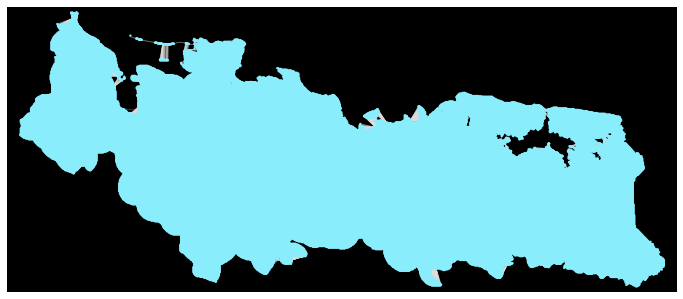

In [465]:
fig, ax = ox.plot_graph(G,
                            figsize=(12,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')